In [11]:
import numpy as np
import pandas as pd

# Data preprocessing

### Read data and save to vector

In [22]:
from sklearn.preprocessing import StandardScaler

X_train_df = pd.read_csv('./data/X_train.csv', skiprows=1, header=None)
y_train_df = pd.read_csv('./data/y_train.csv', skiprows=1, header=None)
X_test_df = pd.read_csv('./data/X_test.csv', skiprows=1, header=None)

X_train_full = X_train_df.values[:, 1:]
y_train_full = y_train_df.values[:, 1:]
X_test = X_test_df.values[:, 1:]

print(X_train_full.shape, y_train_full.shape, X_test.shape)

# Normalize data
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)


(1212, 832) (1212, 1) (776, 832)


The matrix below serves to see how many features seem useful, adjusting k_param

If you see many entries with all correlations around 0 (column or row all 0, then k_param is too high)

/home/diego/src/AML_projects/project1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


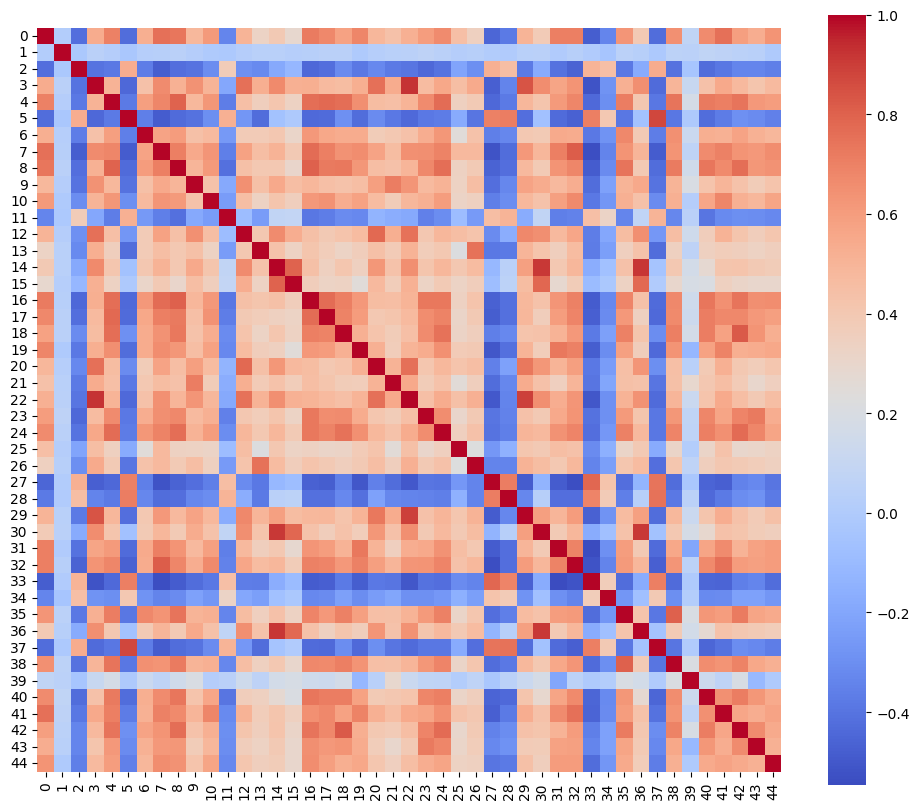

In [10]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt

k_param = 45

X_train = X_train_full
y_train = y_train_full

X_impute = np.nanmean(X_train, axis=0, keepdims=True)
X_train = np.where(np.isnan(X_train), X_impute, X_train)

selector = SelectKBest(mutual_info_regression, k=k_param)
X_selected = selector.fit_transform(X_train, y_train)

corr_matrix = np.corrcoef(X_selected.T)
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, square=True, cbar=True)
plt.show()

### Train and validation set
Used a 70-30 split, can be changed at `testSize=0.3`

In [23]:
from sklearn.model_selection import train_test_split

testSize = 0.3
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = testSize, random_state=42)

In [19]:
# run this if no validation set wanted
X_train = X_train_full
y_train = y_train_full
X_val = X_train 
y_val = y_train

### Imputing missing values with ...

Using mean:

In [14]:
# Impute missing values with mean
X_impute = np.nanmean(X_train, axis=0, keepdims=True)
X_train = np.where(np.isnan(X_train), X_impute, X_train)
X_train_full = np.where(np.isnan(X_train_full), X_impute, X_train_full)
X_val = np.where(np.isnan(X_val), X_impute, X_val)
X_test = np.where(np.isnan(X_test), X_impute, X_test)

Using knn:

In [24]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=30)
X_train = imputer.fit_transform(X_train)

X_train = imputer.transform(X_train)
X_train_full = imputer.transform(X_train_full)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

### Feature selection (dropping certain features)

In [25]:
k_param = 30 #number of features to selct

Using SelectKBest from sklearn

In [16]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Select `k_param` features with highest mutual info
selection = SelectKBest(mutual_info_regression, k=k_param).fit(X_train, y_train)
X_train = selection.transform(X_train)
X_train_full = selection.transform(X_train_full)
X_val = selection.transform(X_val)
X_test = selection.transform(X_test)

/home/diego/src/AML_projects/project1/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Using recursive feature elimination (takes a while to run):

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge

model = Ridge()
rfe = RFE(estimator=model, n_features_to_select=k_param)
X_train = rfe.fit_transform(X_train, y_train)
X_train_full = rfe.transform(X_train_full)
X_val = rfe.transform(X_val)
X_test = rfe.transform(X_test)

Similar to recursive feature elimination, but with lasso:

In [6]:
from sklearn.linear_model import Lasso

eps = 0.001

model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
selected_features = (model.coef_ > eps)
X_train = X_train[:, selected_features]
X_train_full = X_train_full[:, selected_features]
X_val = X_val[:, selected_features]
X_test = X_test[:, selected_features]

Using SVD:

In [31]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=k_param)

X_train = svd.fit_transform(X_train)
X_train_full = svd.transform(X_train_full)
X_val = svd.transform(X_val)
X_test = svd.transform(X_test)

Using PCA:

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=k_param)
X_train = pca.fit_transform(X_train)
X_train_full = pca.transform(X_train_full)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

### Outlier detection

Isolation forest (good for large datasets with unknown distributions)

In [27]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.05)
outliers = iso_forest.fit_predict(X_train)
X_train = X_train[outliers == 1]
y_train = y_train[outliers == 1]

SVM

In [31]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
outliers = one_class_svm.fit_predict(X_train)
X_train = X_train[outliers == 1]
y_train = y_train[outliers == 1]

Using z-score:

In [13]:
from scipy.stats import zscore

outlier_param = 5

z_scores = zscore(X_train)
outliers = np.abs(z_scores) > outlier_param

X_train = X_train[(~outliers).all(axis=1)]
y_train = y_train[(~outliers).all(axis=1)]

IQR (taking everything in [Q1-1.5IQR, Q3+1.5IQR]):

In [267]:
Q1 = np.percentile(X_train, 25, axis=0)
Q3 = np.percentile(X_train, 75, axis=0)
IQR = Q3 - Q1
alpha = 2

lower_bound = Q1 - alpha * IQR
upper_bound = Q3 + alpha * IQR
outliers = (X_train < lower_bound) | (X_train > upper_bound)
X_train = X_train[(~outliers).all(axis=1)]
y_train = y_train[(~outliers).all(axis=1)]

# Model

#### Train model

Simple linear model

In [28]:
from sklearn.linear_model import LinearRegression

# Train a linear regression model
linearRegressor = LinearRegression()
linearRegressor.fit(X_train, y_train)

LinearRegression()

For lasso and ridge we first determine the best alpha value to use:

In [29]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

# Determine best alpha value
alpha_values = [0.001, 0.01, 0.1, 1, 10, 100]
lasso_param_grid = {'alpha': alpha_values}
ridge_param_grid = {'alpha': alpha_values}

lasso = Lasso()
ridge = Ridge()

lasso_search = GridSearchCV(lasso, lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_search = GridSearchCV(ridge, ridge_param_grid, cv=5, scoring='neg_mean_squared_error')

lasso_search.fit(X_train, y_train)
ridge_search.fit(X_train, y_train)

best_alpha_lasso = lasso_search.best_params_['alpha']
best_alpha_ridge = ridge_search.best_params_['alpha']
print(best_alpha_lasso)
print(best_alpha_ridge)

1
100


Then train the model using that alpha value:

In [30]:
lassoRegressor = Lasso(alpha=best_alpha_lasso)
ridgeRegressor = Ridge(alpha=best_alpha_ridge)

lassoRegressor.fit(X_train, y_train)
ridgeRegressor.fit(X_train, y_train)

Ridge(alpha=100)

#### Run predictions
Run predictions and obtain r2 score

In [31]:
from sklearn.metrics import mean_squared_error

lin_y_train_pred = linearRegressor.predict(X_train)
lin_y_val_pred = linearRegressor.predict(X_val)
lin_train_score = mean_squared_error(y_train, lin_y_train_pred)
lin_val_score = mean_squared_error(y_val, lin_y_val_pred)
print('Linear regression score:')
print(lin_train_score, lin_val_score)
print('\n')

lasso_y_train_pred = lassoRegressor.predict(X_train)
lasso_y_val_pred = lassoRegressor.predict(X_val)
lasso_train_score = mean_squared_error(y_train, lasso_y_train_pred)
lasso_val_score = mean_squared_error(y_val, lasso_y_val_pred)
print('Lasso regression score:')
print(lasso_train_score, lasso_val_score)
print('\n')

ridge_y_train_pred = ridgeRegressor.predict(X_train)
ridge_y_val_pred = ridgeRegressor.predict(X_val)
ridge_train_score = mean_squared_error(y_train, ridge_y_train_pred)
ridge_val_score = mean_squared_error(y_val, ridge_y_val_pred)
print('Ridge regression score:')
print(ridge_train_score, ridge_val_score)

Linear regression score:
60.535060051863304 62.183722932636414


Lasso regression score:
63.85196377984807 64.44996177436877


Ridge regression score:
60.54854756360056 62.2068081560895


# Export to csv

In [ ]:
# Exporting to required format for Kaggle
y_train_pred = lassoRegressor.predict(X_train_full)
print(mean_square_error(y_train_full, y_train_pred))

table = pd.DataFrame({'id': np.arange(0, y_train_pred.shape[0]), 'y': y_train_pred.flatten()})
table.to_csv('./data/y_train_pred.csv', index=False)

In [ ]:
# Exporting to required format for Kaggle
y_test_pred = regressor.predict(X_test)

table = pd.DataFrame({'id': np.arrange(0, y_test_pred.shape[0]), 'y': y_test_pred.flatten()})
table.to_csv('./data/y_test_pred.csv', index=False)